In [277]:
import sys
import pandas as pd
import numpy as np
import ipywidgets
from IPython.display import display, HTML

In [2]:
CODE_PATH = r"C:\personal\proj_university\seminar\erp_code"
sys.path.insert(0, CODE_PATH)
import data_ingestion, plot

In [3]:
MAT_PATH = r"C:\personal\proj_university\seminar\Data for example\Itamar_Data.mat"
DATA_NAME = "Data_All"
data = data_ingestion.MatIngest(filename=MAT_PATH, data_name=DATA_NAME).create_data_obj()

In [4]:
for k in data.keys():
    print(k, data[k].shape)

time (512,)
subjects (47,)
group (47,)
conditions (2,)
s30 (47, 512, 21, 2)
s9 (47, 512, 21, 2)
s2 (47, 512, 10, 34)
Legend (4,)
BadSegments (48, 4)
P2range (512,)
N1range (512,)


In [5]:
# Extraction of the timeline as a constant (512,) vector
TIMELINE = data['time']

In [6]:
# function to get Control/Asd subject's idx
def get_groups_idx(data, cont_name='Control', asd_name='ASD', label_name='group'):
    cont_ind = np.where(data[label_name]==cont_name)[0]
    asd_ind = np.where(data[label_name]==asd_name)[0]
    return {cont_name:cont_ind, asd_name:asd_ind}

In [44]:
idx_map = get_groups_idx(data)
cont_id = idx_map['Control']
asd_id = idx_map['ASD']

In [113]:
empty_sigs = np.argwhere(np.all(np.isnan(data['s2']), axis=1)) # 3d-array with shape (#subjects,#trials,#blocks)
df_empty = pd.DataFrame(empty_sigs)
# append subID and group colunms
df_empty = pd.concat(
    [df_empty[0].apply(
        lambda i: pd.Series([data['subjects'][i],data['group'][i]])), 
     df_empty[[1,2]]],
    axis=1)

Preparation of Dashboards

In [189]:
# avearging chronological order: trial-->block-->subject
def group_erp_block_trial_range(fig, df, group_name, block_range, trial_range, timeline, cmap):
    idx = get_groups_idx(data)[group_name]
    sig = np.nanmean(data['s2'][idx, # subjects range
                                :, # time
                                trial_range[0]:trial_range[1], # trials
                                block_range[0]:block_range[1]], # blocks
                     axis=2) # averaging over trials
    
    sig = np.nanmean(sig, axis=2) # averaging over blocks
    sig = np.nanmean(sig, axis=0) # averaging over subjects
    
    gos = plot.go_signal(sig, timeline, 
                         name = 
                         f'{group_name}, {block_range[0]}-{block_range[1]}, {trial_range[0]}-{trial_range[1]}',
                        line_color=cmap[group_name])
    fig.add_trace(gos)

    fig.show()

In [190]:
def dash_group():
    fig = plot.init_trial()
    title_text = "Group Dynamic Within a Given Block-trial Ranges"
    fig.update_layout(title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'text':title_text},
                     font={'family':'Arial'},
                     legend_title_text='Group, Blocks, Trials')


    # interactive
    dash = ipywidgets.interactive(group_erp_block_trial_range, {'manual': True}, 
                                      fig=ipywidgets.fixed(fig),
                                      group_name=ipywidgets.Dropdown(options=['Control','ASD']),
                                      block_range=ipywidgets.SelectionRangeSlider(options=list(range(0,34+1)),
                                                                              description='blocks',
                                                                              value=(0, 1),
                                                                                  layout={'width': '500px'}),
                                      trial_range=ipywidgets.SelectionRangeSlider(options=list(range(0,10+1)),
                                                                              description='trials',
                                                                              value=(0, 9)),
                                      timeline=ipywidgets.fixed(TIMELINE),
                                     cmap=ipywidgets.fixed({"Control":"royalblue", "ASD":"yellowgreen"}))

    return(dash)

In [301]:
# avearging chronological order: trial-->block-->subject
def subject_erp_block_trial_range(fig, sub_id, block_range, trial_range, timeline, cmap):
    idx = np.argwhere(data['subjects']==sub_id).flatten()[0]
    group = data['group'][idx]
    
    sig = np.nanmean(data['s2'][idx, # subject
                                :, # time
                                trial_range[0]:trial_range[1], # trials
                                block_range[0]:block_range[1]], # blocks
                     axis=1) # averaging over trials
    
    sig = np.nanmean(sig, axis=1) # averaging over blocks
    
    # patch - to move to another fucntionality
    start_N1, stop_N1 = get_t_idx(timeline,[70,130])
    start_P2, stop_P2 = get_t_idx(timeline,[150,250])
    N1 = sig[start_N1:stop_N1]
    P2 = sig[start_P2:stop_P2]
    
    
    gos = plot.go_signal(sig, timeline,
                         name = 
                         f'{sub_id} | '\
                         f'{block_range[0]}-{block_range[1]} | '\
                         f'{trial_range[0]}-{trial_range[1]} | '\
                         f'{np.round(rms(N1),2)} | {np.round(rms(P2),2)}',
                        line_color=cmap[group],
                        showlegend=True)
    fig.add_trace(gos)

    fig.show()

In [302]:
def dash_sub():
    fig = plot.init_trial()
    title_text = "Subject Dynamic Within a Given Block-trial Ranges"
    fig.update_layout(title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'text':title_text},
                     font={'family':'Arial'},
                     legend_title_text='Sub | Blocks | Trials | rms(N1) | rms(P2)')

    sub_dropdown_labels = list(zip(data['group'] + " " + data['subjects'],data['subjects']))

    # interactive
    dash_sub = ipywidgets.interactive(subject_erp_block_trial_range, {'manual': True}, 
                                      fig=ipywidgets.fixed(fig),
                                      rms_df=ipywidgets.fixed(rms_df),
                                      sub_id=ipywidgets.Dropdown(options=sub_dropdown_labels),
                                      block_range=ipywidgets.SelectionRangeSlider(options=list(range(0,34+1)),
                                                                              description='blocks',
                                                                              value=(0, 1),
                                                                                  layout={'width': '500px'}),
                                      trial_range=ipywidgets.SelectionRangeSlider(options=list(range(0,10+1)),
                                                                              description='trials',
                                                                              value=(0, 9)),
                                      timeline=ipywidgets.fixed(TIMELINE),
                                     cmap=ipywidgets.fixed({"Control":"royalblue", "ASD":"yellowgreen"}))

    return(dash_sub)

##### Interactive Dashboard 1 Group: 
Group ERP Dynamics over a given Range of Blokcs and Trials \
(clear dashboard by re-run the next cell)

In [193]:
dash_group()

interactive(children=(Dropdown(description='group_name', options=('Control', 'ASD'), value='Control'), Selecti…

##### Interactive Dashboard 2 Subject: 
Individuals ERP Dynamics over a given Range of Blokcs and Trials \
(clear dashboard by re-run the next cell)

In [303]:
dash_sub()

interactive(children=(Dropdown(description='sub_id', options=(('ASD AHRO3469', 'AHRO3469'), ('ASD ARBE3445', '…

#### Transient and Sustained Comparison
The steps are detailed in the attached Email

In [9]:
#function to get data for transient/sustained part of specific block
# returns ndarray of shape (25,512,5)
def get_group_partial_data(data, group, trial_range, block_range):
    idx = get_groups_idx(data)[group]
        return data['s2'][idx,:,trial_range[0]:trial_range[1],block_range[0]:block_range[1]]

# function to compute Area Under Curve of averaged signal 
# three_d_arr is of shape (25 or 23,512,5)
def group_auc(three_d_arr):
    # Averaging over tran/sust trials and then over subjects
    sig = np.nanmean(np.nanmean(three_d_arr, axis=2), axis=0) # a signal (512,)
    return np.trapz(y=np.abs(sig),x=TIMELINE) # a float (auc)

In [7]:
BLOCKS = np.arange(data['s2'].shape[3])

In [11]:
cont_transs_auc = []
cont_suss_auc = []
asd_transs_auc = []
asd_suss_auc = []
for bl in BLOCKS:
    # computing transient/sustained data for all blocks for the both groups
    cont_tran = get_half_block("transient", data, 'Control', bl)
    cont_sus = get_half_block("sustained", data, 'Control', bl)
    asd_tran = get_half_block("transient", data, 'ASD', bl)
    asd_sus = get_half_block("sustained", data, 'ASD', bl)
    
    # appending auc (for plotting in the next step)
    cont_transs_auc.append(group_auc(cont_tran))
    cont_suss_auc.append(group_auc(cont_sus))
    asd_transs_auc.append(group_auc(asd_tran))
    asd_suss_auc.append(group_auc(asd_sus))

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

Mean of empty slice



In [308]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1, subplot_titles=("Control", "ASD"))

#cont
fig.add_trace(
    go.Scatter(x=BLOCKS, y=cont_transs_auc,
               name="cont_transient", marker=dict(color="royalblue"), mode="lines+markers"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=BLOCKS, y=cont_suss_auc,
               name="cont_sustained",marker=dict(color="firebrick"), mode="lines+markers"),
    row=1, col=1
)

#asd
fig.add_trace(
    go.Scatter(x=BLOCKS, y=asd_transs_auc,
               name="asd_transient", marker=dict(color="royalblue"), mode="lines+markers"),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=BLOCKS, y=asd_suss_auc,
               name="asd_sustained", marker=dict(color="firebrick"), mode="lines+markers"),
    row=2, col=1
)

fig.update_xaxes(title_text='block number')
fig.update_yaxes(title_text='AUC')
fig.update_layout(title_text="Area Under Curve of Transient/Sustained Voltage Comparison", title_font={"family":"Arial"})
# fig.show(renderer="iframe")
fig.show()

NameError: name 'BLOCKS' is not defined

In [267]:
# t is a vector
def get_t_idx(timeline, t):
    vf = np.vectorize(lambda t: np.argmin(np.abs(timeline-t)))
    return vf(t) # idxes for corresponding t (same length)
    
    
start_idx, stop_idx = np.argmin(np.abs(TIMELINE)), np.argmin(np.abs(TIMELINE-500))

In [271]:
get_t_idx(TIMELINE,[70,130])

array([162, 177], dtype=int64)

In [265]:
vfunc = np.vectorize(lambda t: np.argmin(np.abs(TIMELINE-t)))
vfunc([0,500])

array([144, 272], dtype=int64)

#### RMS post-onset ~500 ms
stam bla bla

In [13]:
def rms(x,y):
    return np.sqrt(np.trapz(y=y**2, x=x))

In [14]:
start_idx, stop_idx = np.argmin(np.abs(TIMELINE)), np.argmin(np.abs(TIMELINE-500))

In [15]:
def group_rms(data, start, stop, group_id, block):
    sig = np.nanmean(data['s2'][group_id,start:stop,:,block], axis=2) # over trials
    sig = np.nanmean(sig,0) # over subjects
    return(rms(x=TIMELINE[start:stop], y=sig))

In [16]:
cont_rms = [group_rms(data,start_idx,stop_idx,idx_map['Control'], bl) for bl in BLOCKS]
asd_rms = [group_rms(data,start_idx,stop_idx,idx_map['ASD'], bl) for bl in BLOCKS]

C:\Users\yuvalf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice



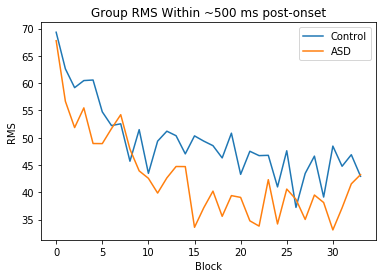

In [17]:
import matplotlib.pyplot as plt
plt.title("Group RMS Within ~500 ms post-onset")
plt.xlabel("Block")
plt.ylabel("RMS")
plt.plot(BLOCKS, cont_rms, label='Control')
plt.plot(BLOCKS, asd_rms, label='ASD')
plt.legend()
plt.show()

#### N1 magnitude
stam bla bla

In [10]:
start_N1, stop_N1 = np.argmin(np.abs(TIMELINE-70)), np.argmin(np.abs(TIMELINE-130))
start_P2, stop_P2 = np.argmin(np.abs(TIMELINE-150)), np.argmin(np.abs(TIMELINE-250))

In [36]:
def group_peak(data, peak, start, stop, group_id, block):
    sig = np.nanmean(data['s2'][group_id,start:stop,:,block], axis=2) # over trials
    sig = np.nanmean(sig,0) # over subjects
    if peak=="N1":
        return(np.min(sig))
    if peak=="P2":
        return(np.max(sig))

In [37]:
# cont_N1 = [group_peak(data,"N1",start_N1,stop_N1,idx_map['Control'],bl) for bl in BLOCKS]
# asd_N1 = [group_peak(data,"N1",start_N1,stop_N1,idx_map['ASD'],bl) for bl in BLOCKS]
# cont_P2 = [group_peak(data,"P2",start_P2,stop_P2,idx_map['Control'],bl) for bl in BLOCKS]
# asd_P2 = [group_peak(data,"P2",start_P2,stop_P2,idx_map['ASD'],bl) for bl in BLOCKS]

C:\Users\yuvalf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice



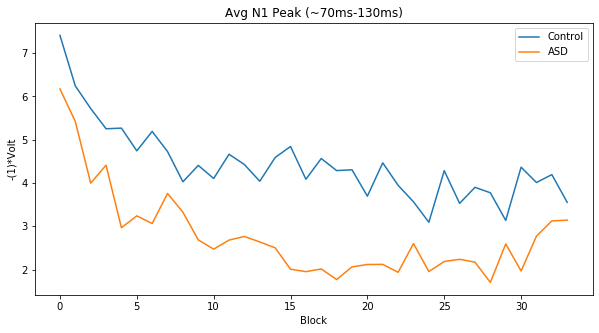

In [57]:
# fig, ax = plt.subplots(2,1,constrained_layout=True)

# ax[0].plot(BLOCKS, -np.array(cont_N1), label='Control')
# ax[0].plot(BLOCKS, -np.array(asd_N1), label='ASD')
# ax[0].set_title("N1 min(70-130)")

# ax[1].plot(BLOCKS, np.array(cont_P2), label='Control')
# ax[1].plot(BLOCKS, np.array(asd_P2), label='ASD')
# ax[1].set_title("P2 max(150-250)")

# handles, labels = ax[1].get_legend_handles_labels()
# fig.legend(handles, labels)
# plt.show()

plt.figure(figsize=(10,5))
plt.title("Avg N1 Peak (~70ms-130ms)")
plt.xlabel("Block")
plt.ylabel("-(1)*Volt")
plt.plot(BLOCKS, -np.array(cont_N1), label='Control')
plt.plot(BLOCKS, -np.array(asd_N1), label='ASD')
plt.legend()
plt.show()

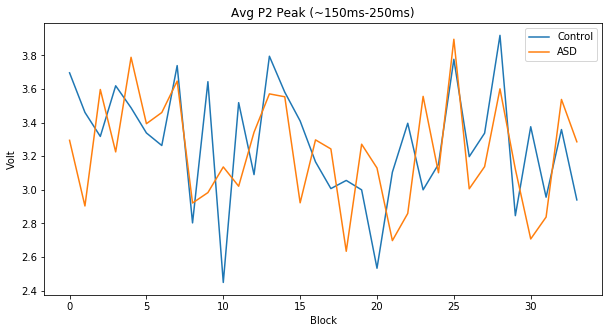

In [56]:
plt.figure(figsize=(10,5))
plt.title("Avg P2 Peak (~150ms-250ms)")
plt.xlabel("Block")
plt.ylabel("Volt")
plt.plot(BLOCKS, cont_P2, label='Control')
plt.plot(BLOCKS, asd_P2, label='ASD')
plt.legend()
plt.show()

#### Within Block
stam bla bla

In [9]:
def group_peak(data, peak, start, stop, between, group_id, block):
    sig = np.nanmean(data['s2'][group_id,start:stop,between[0]:between[1],block], axis=2) # over trials
    sig = np.nanmean(sig,0) # over subjects
    if peak=="N1":
        return(np.min(sig))
    if peak=="P2":
        return(np.max(sig))

In [28]:
d = {'Control':np.zeros((34,10)), 'ASD':np.zeros((34,10))}

for gr in d.keys():
    for bl in BLOCKS:
        for i in range(10):
            d[gr][bl,i] = group_peak(data,"N1",start_N1,stop_N1,(i,i+1),idx_map[gr],bl)

C:\Users\yuvalf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice



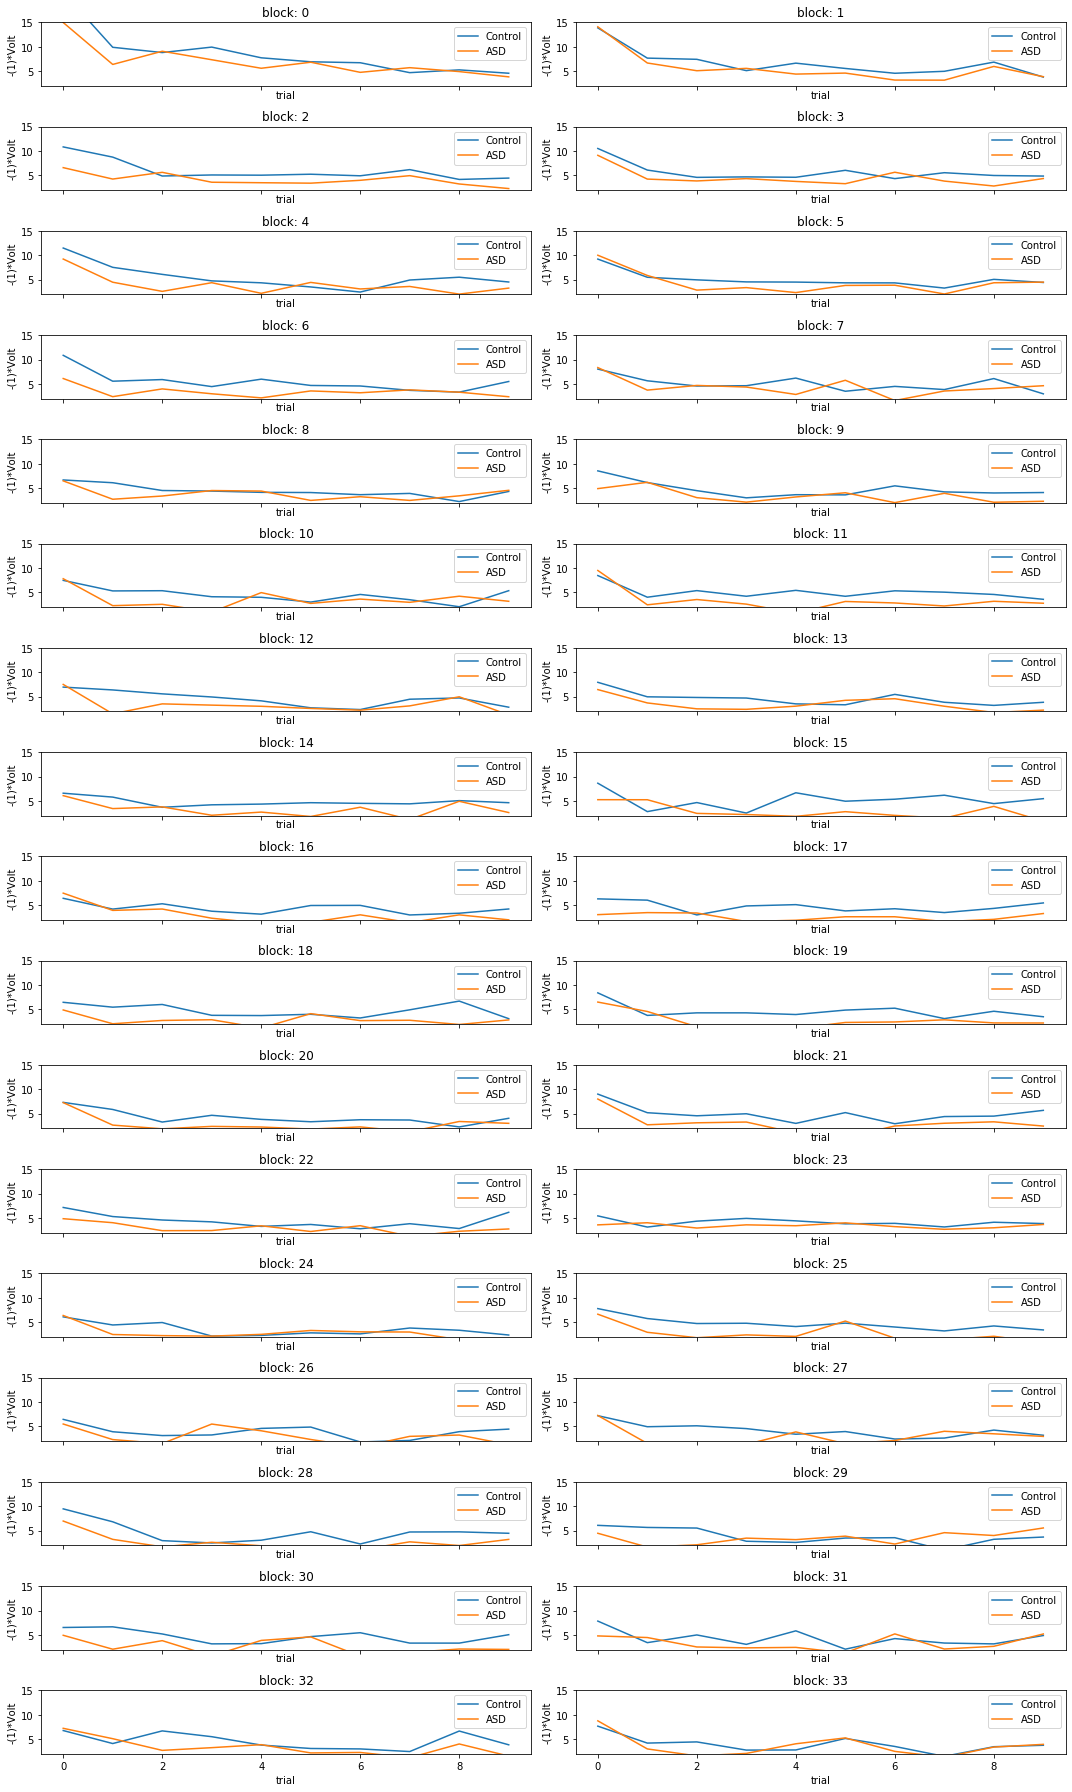

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(17,2,sharex=True, figsize=(15,25))

for bl, ax in enumerate(axs.flatten()):
    ax.plot(np.arange(10),-d['Control'][bl,:], label="Control")
    ax.plot(np.arange(10),-d['ASD'][bl,:], label="ASD")
    ax.set_xlabel("trial")
    ax.set_ylabel("-(1)*Volt")
    ax.set_title(f"block: {bl}")
    ax.set_ylim(2,15)
    ax.legend()

fig.tight_layout()
plt.savefig("N1_Within_Block.png")
plt.show()


In [37]:
ax.flatten()

(34,)

In [243]:
fig['data'][0]['x']

True

In [252]:
def rms(arr, baseline=0, **kwargs):
    return np.sqrt(np.nanmean((arr-baseline)**2, **kwargs))

In [253]:
t = np.random.normal(scale=10,size=(3,2))
rms(t)

6.137475499868572

In [255]:
rms(data['s2'][3,:,5,3])

10.101829357264021

In [247]:
pd.DataFrame(None, columns=["N1","P2"])

,N1,P2


In [304]:
import warnings

In [306]:
warnings.filterwarnings(action="ignore", message="Mean of empty slice", category=RuntimeWarning)

In [307]:
np.nanmean(np.array([np.nan,np.nan]))

nan